# Imports and Data

In [340]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [341]:
words = pd.read_csv('../data/collage_words.csv').dropna()
cats = pd.read_csv('../data/Categories.csv').dropna()

In [342]:
catwise = cats.groupby(by=['Category']).agg(lambda x: ", ".join(x)).squeeze()
car_brands = catwise['Cars'].split(", ")

brandwise = words.groupby(by=['Brand']).agg(lambda x: ", ".join(x)).squeeze()
brandwise_cars = brandwise[brandwise.index.isin(car_brands)]

# LDA Topics Recognition

In [343]:
car_words = brandwise_cars.values

In [344]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=10)
lda = LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=101)
X = count_vectorizer.fit_transform(car_words)

In [345]:
doc_topic = lda.fit_transform(X)

In [346]:
topic_word = lda.components_
most_relevant_words = np.flip(np.argsort(topic_word, axis=1), axis=1)[:, :50]

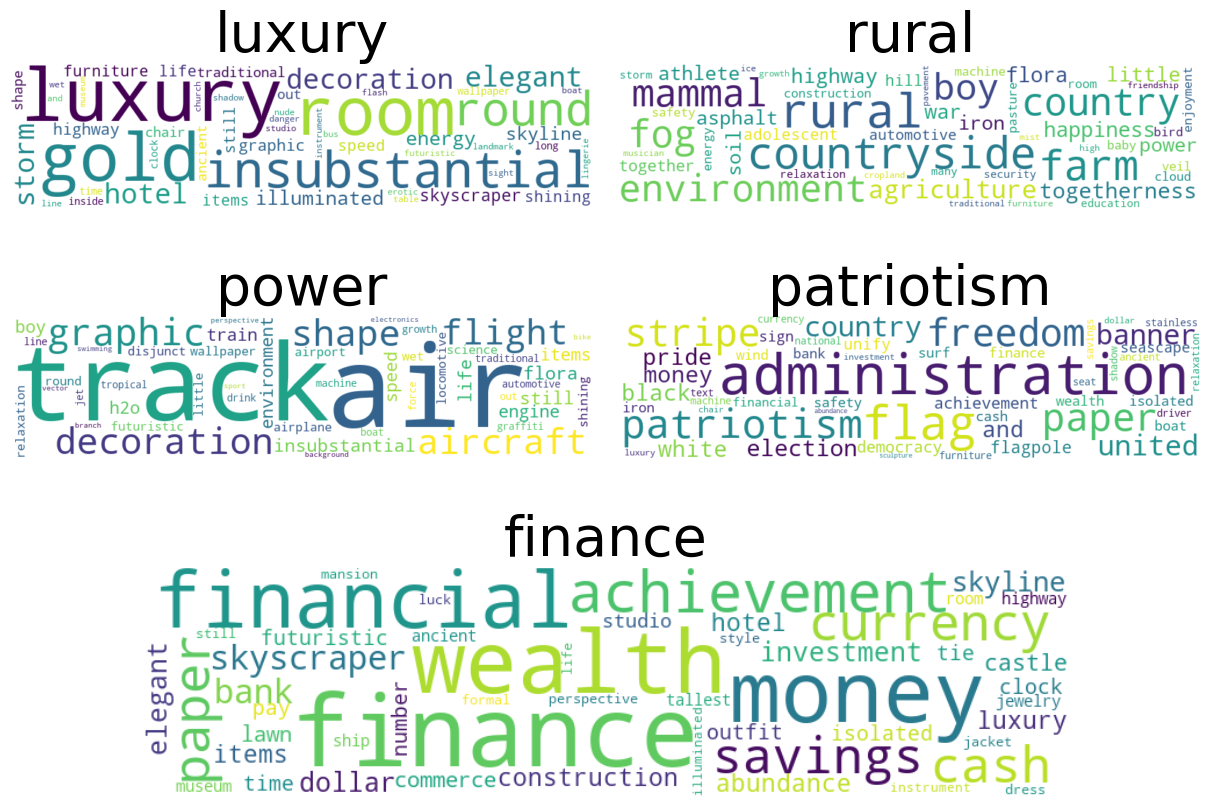

In [347]:
def plot_word_clouds(titles):
    fig, axs = plt.subplot_mosaic([[0, 1], [2, 3], [4, 4]], constrained_layout=True)

    for i, (row, ax) in enumerate(zip(most_relevant_words, axs.values())):
        words, freqs = count_vectorizer.get_feature_names_out()[row], topic_word[i, row]
        word_freq_dict = dict(zip(words, freqs))

        cloud = WordCloud(background_color='white', width=800).generate_from_frequencies(word_freq_dict)

        ax.set_title(titles[i], fontsize=40)
        ax.imshow(cloud, interpolation='bilinear')
        ax.axis('off')

    plt.show()


topic_labels = ['luxury', 'rural', 'power', 'patriotism', 'finance']
plot_word_clouds(topic_labels)

# TF-IDF Brands Description

Now let's look at the most popular words for different car brands

In [348]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05)
tf_idf = np.array(vectorizer.fit_transform(brandwise_cars.values).todense())
ids = np.flip(tf_idf.argsort(axis=1), axis=1)

In [349]:
car_idx = [brandwise_cars.index.get_loc(brand) for brand in car_brands]

tf_idf_words = vectorizer.get_feature_names_out()
most_relevant_brand_words = [
    (brand, tf_idf_words[ids[i, :50]])
    for i, brand in zip(car_idx, car_brands)
]
most_relevant_brand_words = np.array(most_relevant_brand_words, dtype='object')

As we can see, some of these make no sense for us. Let's then create a score that says how similar a brand to a topic

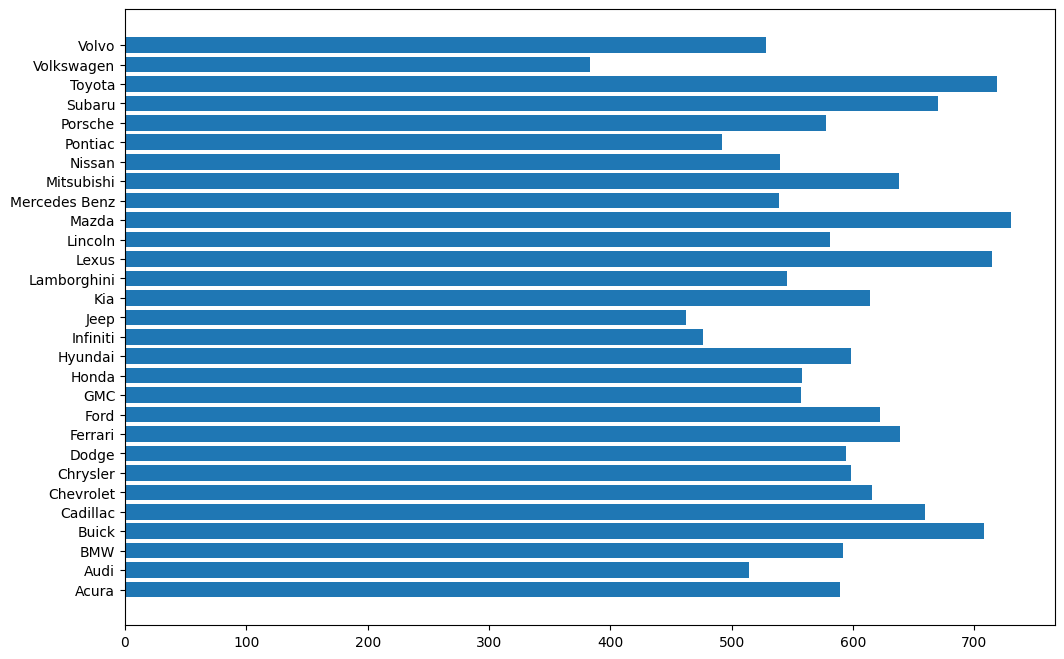

In [350]:
lens = np.sum(tf_idf > 0, axis=1)

plt.barh(range(len(car_brands)), lens)
plt.yticks(range(len(car_brands)), car_brands)
plt.show()

That's lenghts of clouds. So 50 is at most 10% in one case almost 20%. Is it too much? Idk

# Matching Brands and Topics

In [351]:
most_relevant_topic_words = [count_vectorizer.get_feature_names_out()[row] for row in most_relevant_words]

In [368]:
def score_to_df(score):
    score = (score.T / score.sum(axis=1)).T
    score = pd.DataFrame(score, columns=topic_labels, index=car_brands)
    return score, *clean_scores(score)


def clean_scores(score):
    score_cleaned = score.apply(lambda x: np.where(x > 0.1, x, 0))
    score_cleaned_bi = score.apply(lambda x: np.where(x > 0.1, 1, 0))
    return score_cleaned, score_cleaned_bi

In [369]:
from sklearn.metrics.pairwise import cosine_similarity


def jaccard(wordset_1, wordset_2):
    intersection = set(wordset_1).intersection(set(wordset_2))
    union = set(wordset_1).union(set(wordset_2))
    return len(intersection) / len(union)

Curiously, these things don't change majorly when we change number of top words used. Sure, number of topics change, but Toyota will always be rural. That's a good sign.

In [371]:
scores_jaccard = [jaccard(bw, tw)
                  for bw in most_relevant_brand_words[:, 1]
                  for tw in most_relevant_topic_words]
scores_jaccard = np.array(scores_jaccard).reshape(29, 5)

scores_jaccard_df = score_to_df(scores_jaccard)
scores_jaccard_df[2]

,luxury,rural,power,patriotism,finance
Acura,1,1,0,1,1
Audi,1,0,0,0,1
BMW,1,0,0,1,1
Buick,1,1,0,1,1
Cadillac,1,0,1,1,1
Chevrolet,0,1,1,0,0
Chrysler,0,0,0,1,1
Dodge,0,1,0,1,0
Ferrari,1,1,1,1,1
Ford,1,1,0,1,0


In [372]:
intersection = set(vectorizer.get_feature_names_out()).intersection(count_vectorizer.get_feature_names_out())

tf_idf_lim = pd.DataFrame(tf_idf, columns=vectorizer.get_feature_names_out(), index=car_brands)
tf_idf_lim = tf_idf_lim[list(intersection)]

scores_cosine = cosine_similarity(tf_idf_lim, topic_word)
scores_cosine_df = score_to_df(scores_cosine)
scores_jaccard_df[2]

,luxury,rural,power,patriotism,finance
Acura,1,1,0,1,1
Audi,1,0,0,0,1
BMW,1,0,0,1,1
Buick,1,1,0,1,1
Cadillac,1,0,1,1,1
Chevrolet,0,1,1,0,0
Chrysler,0,0,0,1,1
Dodge,0,1,0,1,0
Ferrari,1,1,1,1,1
Ford,1,1,0,1,0


In [392]:
scores_lda_df = score_to_df(doc_topic)

In [403]:
def res(a,b):
    print([np.isclose(a[i],b[i], rtol=0.1).sum() for i in range(3)])

s = scores_jaccard_df, scores_cosine_df, scores_lda_df
s_label = ['jac', 'cos', 'lda']
for i in range(3):
    for j in range(i+1, 3):
        print(s_label[i], s_label[j], end=': ')
        res(s[i], s[j])

jac cos: [10, 10, 96]
jac lda: [11, 52, 99]
cos lda: [5, 5, 62]
